In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
np.load.__defaults__=(None, True, True, 'ASCII')

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
class HParams():
    def __init__(self):
        self.data_location = '../Datasets/sketchrnn_chair.npz'
        self.enc_hidden_size = 256
        self.dec_hidden_size = 512
        self.Nz = 128
        self.M = 20
        self.dropout = 0.9
        self.batch_size = 100
        self.eta_min = 0.01
        self.R = 0.99995
        self.KL_min = 0.2
        self.wKL = 0.5
        self.lr = 0.001
        self.lr_decay = 0.9999
        self.min_lr = 0.00001
        self.grad_clip = 1.
        self.temperature = 0.4
        self.max_seq_length = 200

hp = HParams()

In [3]:
def max_size(data):
    """larger sequence length in the data set"""
    sizes = [len(seq) for seq in data]
    return max(sizes)

def purify(strokes):
    """removes to small or too long sequences + removes large gaps"""
    data = []
    for seq in strokes:
        if seq.shape[0] <= hp.max_seq_length and seq.shape[0] > 10:
            seq = np.minimum(seq, 1000)
            seq = np.maximum(seq, -1000)
            seq = np.array(seq, dtype=np.float32)
            data.append(seq)
    return data

def calculate_normalizing_scale_factor(strokes):
    """Calculate the normalizing factor explained in appendix of sketch-rnn."""
    data = []
    for i in range(len(strokes)):
        for j in range(len(strokes[i])):
            data.append(strokes[i][j, 0])
            data.append(strokes[i][j, 1])
    data = np.array(data)
    return np.std(data)

def normalize(strokes):
    """Normalize entire dataset (delta_x, delta_y) by the scaling factor."""
    data = []
    scale_factor = calculate_normalizing_scale_factor(strokes)
    for seq in strokes:
        seq[:, 0:2] /= scale_factor
        data.append(seq)
    return data

dataset = np.load(hp.data_location, encoding='latin1')
data = dataset['train']
data = purify(data)
data = normalize(data)
Nmax = max_size(data)

In [4]:
def make_batch(batch_size):
    batch_idx = np.random.choice(len(data),batch_size)
    batch_sequences = [data[idx] for idx in batch_idx]
    strokes = []
    lengths = []
    indice = 0
    for seq in batch_sequences:
        len_seq = len(seq[:,0])
        new_seq = np.zeros((Nmax,5)) # 66,5
        new_seq[:len_seq,:2] = seq[:,:2]
        new_seq[:len_seq-1,2] = 1-seq[:-1,2]
        new_seq[:len_seq,3] = seq[:,2]
        new_seq[(len_seq-1):,4] = 1
        new_seq[len_seq-1,2:4] = 0
        lengths.append(len(seq[:,0]))
        strokes.append(new_seq)
        indice += 1

    if use_cuda:
        batch = Variable(torch.from_numpy(np.stack(strokes,1)).cuda().float())
    else:
        batch = Variable(torch.from_numpy(np.stack(strokes,1)).float())
    return batch, lengths

In [5]:
def lr_decay(optimizer):
    """Decay learning rate by a factor of lr_decay"""
    for param_group in optimizer.param_groups:
        if param_group['lr']>hp.min_lr:
            param_group['lr'] *= hp.lr_decay
    return optimizer

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self):
        super(EncoderRNN, self).__init__()
        # bidirectional lstm:
        self.lstm = nn.LSTM(5, hp.enc_hidden_size, \
            dropout=hp.dropout, bidirectional=True)
        # create mu and sigma from lstm's last output:
        self.fc_mu = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        self.fc_sigma = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        # active dropout:
        self.train()

    def forward(self, inputs, batch_size, hidden_cell=None):
        if hidden_cell is None:
            # then must init with zeros
            if use_cuda:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
            else:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size)
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size)
            hidden_cell = (hidden, cell)
        _, (hidden,cell) = self.lstm(inputs.float(), hidden_cell)
        # hidden is (2, batch_size, hidden_size), we want (batch_size, 2*hidden_size):
        hidden_forward, hidden_backward = torch.split(hidden,1,0)
        hidden_cat = torch.cat([hidden_forward.squeeze(0), hidden_backward.squeeze(0)],1)
        # mu and sigma:
        mu = self.fc_mu(hidden_cat)
        sigma_hat = self.fc_sigma(hidden_cat)
        sigma = torch.exp(sigma_hat/2.)
        # N ~ N(0,1)
        z_size = mu.size()
                                   
        if use_cuda:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size)).cuda()
        else:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size))
        z = mu + sigma*N
        # mu and sigma_hat are needed for LKL loss
        return z, mu, sigma_hat

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        # to init hidden and cell from z:
        self.fc_hc = nn.Linear(hp.Nz, 2*hp.dec_hidden_size)
        # unidirectional lstm:
        self.lstm = nn.LSTM(hp.Nz+5, hp.dec_hidden_size, dropout=hp.dropout)
        # create proba distribution parameters from hiddens:
        self.fc_params = nn.Linear(hp.dec_hidden_size,6*hp.M+3)

    def forward(self, inputs, z, hidden_cell=None):
        if hidden_cell is None:
            # then we must init from z
            hidden,cell = torch.split(F.tanh(self.fc_hc(z)),hp.dec_hidden_size,1)
            hidden_cell = (hidden.unsqueeze(0).contiguous(), cell.unsqueeze(0).contiguous())
        outputs,(hidden,cell) = self.lstm(inputs, hidden_cell)
        # in training we feed the lstm with the whole input in one shot
        # and use all outputs contained in 'outputs', while in generate
        # mode we just feed with the last generated sample:
        if self.training:
            y = self.fc_params(outputs.view(-1, hp.dec_hidden_size))
        else:
            y = self.fc_params(hidden.view(-1, hp.dec_hidden_size))
        # separate pen and mixture params:
        params = torch.split(y,6,1)
        params_mixture = torch.stack(params[:-1]) # trajectory
        params_pen = params[-1] # pen up/down
        # identify mixture params:
        pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy = torch.split(params_mixture,1,2)
        # preprocess params::
        if self.training:
            len_out = Nmax+1
        else:
            len_out = 1
                                   
        pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_x = torch.exp(sigma_x.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_y = torch.exp(sigma_y.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        rho_xy = torch.tanh(rho_xy.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        mu_x = mu_x.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        mu_y = mu_y.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        q = F.softmax(params_pen).view(len_out,-1,3)
        return pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy,q,hidden,cell

In [8]:
class Model():
    def __init__(self):
        if use_cuda:
            self.encoder = EncoderRNN().cuda()
            self.decoder = DecoderRNN().cuda()
        else:
            self.encoder = EncoderRNN()
            self.decoder = DecoderRNN()
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), hp.lr)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), hp.lr)
        self.eta_step = hp.eta_min

    def make_target(self, batch, lengths):
        if use_cuda:
            eos = torch.stack([torch.Tensor([0,0,0,0,1])]*batch.size()[1]).cuda().unsqueeze(0)
        else:
            eos = torch.stack([torch.Tensor([0,0,0,0,1])]*batch.size()[1]).unsqueeze(0)
        batch = torch.cat([batch, eos], 0)
        mask = torch.zeros(Nmax+1, batch.size()[1])
        for indice,length in enumerate(lengths):
            mask[:length,indice] = 1
        if use_cuda:
            mask = mask.cuda()
        dx = torch.stack([batch.data[:,:,0]]*hp.M,2)
        dy = torch.stack([batch.data[:,:,1]]*hp.M,2)
        p1 = batch.data[:,:,2]
        p2 = batch.data[:,:,3]
        p3 = batch.data[:,:,4]
        p = torch.stack([p1,p2,p3],2)
        return mask,dx,dy,p

    def train(self, epoch):
        self.encoder.train()
        self.decoder.train()
        batch, lengths = make_batch(hp.batch_size)
        # encode:
        z, self.mu, self.sigma = self.encoder(batch, hp.batch_size)
        # create start of sequence:
        if use_cuda:
            sos = torch.stack([torch.Tensor([0,0,1,0,0])]*hp.batch_size).cuda().unsqueeze(0)
        else:
            sos = torch.stack([torch.Tensor([0,0,1,0,0])]*hp.batch_size).unsqueeze(0)
        # had sos at the begining of the batch:
        batch_init = torch.cat([sos, batch],0)
        # expend z to be ready to concatenate with inputs:
        z_stack = torch.stack([z]*(Nmax+1))
        # inputs is concatenation of z and batch_inputs
        inputs = torch.cat([batch_init, z_stack],2)
        # decode:
        self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
            self.rho_xy, self.q, _, _ = self.decoder(inputs, z)
        # prepare targets:
        mask,dx,dy,p = self.make_target(batch, lengths)
        # prepare optimizers:
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        # update eta for LKL:
        self.eta_step = 1-(1-hp.eta_min)*hp.R
        # compute losses:
        LKL = self.kullback_leibler_loss()
        LR = self.reconstruction_loss(mask,dx,dy,p,epoch)
        loss = LR + LKL
        # gradient step
        loss.backward()
        # gradient cliping
        nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
        nn.utils.clip_grad_norm(self.decoder.parameters(), hp.grad_clip)
        # optim step
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        # some print and save:
        print(f"The number of epochs is: {epoch}")
        if epoch%1==0:
#             print('epoch',epoch,'loss',loss.data[0],'LR',LR.data[0],'LKL',LKL.data[0])
            self.encoder_optimizer = lr_decay(self.encoder_optimizer)
            self.decoder_optimizer = lr_decay(self.decoder_optimizer)
        if epoch%100==0:
            self.save(epoch)
            self.conditional_generation(epoch)

    def bivariate_normal_pdf(self, dx, dy):
        z_x = ((dx-self.mu_x)/self.sigma_x)**2
        z_y = ((dy-self.mu_y)/self.sigma_y)**2
        z_xy = (dx-self.mu_x)*(dy-self.mu_y)/(self.sigma_x*self.sigma_y)
        z = z_x + z_y -2*self.rho_xy*z_xy
        exp = torch.exp(-z/(2*(1-self.rho_xy**2)))
        norm = 2*np.pi*self.sigma_x*self.sigma_y*torch.sqrt(1-self.rho_xy**2)
        return exp/norm

    def reconstruction_loss(self, mask, dx, dy, p, epoch):
        pdf = self.bivariate_normal_pdf(dx, dy)
        LS = -torch.sum(mask*torch.log(1e-5+torch.sum(self.pi * pdf, 2)))\
            /float(Nmax*hp.batch_size)
        LP = -torch.sum(p*torch.log(self.q))/float(Nmax*hp.batch_size)
        return LS+LP

    def kullback_leibler_loss(self):
        LKL = -0.5*torch.sum(1+self.sigma-self.mu**2-torch.exp(self.sigma))\
            /float(hp.Nz*hp.batch_size)
        if use_cuda:
            KL_min = Variable(torch.Tensor([hp.KL_min]).cuda()).detach()
        else:
            KL_min = Variable(torch.Tensor([hp.KL_min])).detach()
        return hp.wKL*self.eta_step * torch.max(LKL,KL_min)

    def save(self, epoch):
        random_number = np.random.rand()
        enc_model_name = 'sketchRNN_encoder_%3f_%d.pt' % (random_number, epoch)
        enc_path = F"../Models_Chairs/{enc_model_name}"
        torch.save(self.encoder.state_dict(), enc_path)
        dec_model_name = 'sketchRNN_decoder_%3f_%d.pt' % (random_number, epoch)
        dec_path = F"../Models_Chairs/{dec_model_name}"
        torch.save(self.decoder.state_dict(), dec_path)
        
#         torch.save(self.encoder.state_dict(), 'encoderRNN_sel_%3f_epoch_%d.pth' % (sel,epoch))
#         torch.save(self.decoder.state_dict(), 'decoderRNN_sel_%3f_epoch_%d.pth' % (sel,epoch))

    def load(self, encoder_name, decoder_name):
        saved_encoder = torch.load(encoder_name)
        saved_decoder = torch.load(decoder_name)
        self.encoder.load_state_dict(saved_encoder)
        self.decoder.load_state_dict(saved_decoder)

    def conditional_generation(self, epoch):
        batch,lengths = make_batch(1)
        # should remove dropouts:
        self.encoder.train(False)
        self.decoder.train(False)
        # encode:
        z, _, _ = self.encoder(batch, 1)
        if use_cuda:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1).cuda())
        else:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1))
        s = sos
        seq_x = []
        seq_y = []
        seq_z = []
        hidden_cell = None
        for i in range(Nmax):
            input = torch.cat([s,z.unsqueeze(0)],2)
            # decode:
            self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
                self.rho_xy, self.q, hidden, cell = \
                    self.decoder(input, z, hidden_cell)
            hidden_cell = (hidden, cell)
            # sample from parameters:
            s, dx, dy, pen_down, eos = self.sample_next_state()
            #------
            seq_x.append(dx)
            seq_y.append(dy)
            seq_z.append(pen_down)
            if eos:
                print(i)
                break
        # visualize result:
        x_sample = np.cumsum(seq_x, 0)
        y_sample = np.cumsum(seq_y, 0)
        z_sample = np.array(seq_z)
        sequence = np.stack([x_sample,y_sample,z_sample]).T
        make_image(sequence, epoch)

    def sample_next_state(self):
        def adjust_temp(pi_pdf):
            pi_pdf = np.log(pi_pdf)/hp.temperature
            pi_pdf -= pi_pdf.max()
            pi_pdf = np.exp(pi_pdf)
            pi_pdf /= pi_pdf.sum()
            return pi_pdf

        # get mixture indice:
        pi = self.pi.data[0,0,:].cpu().numpy()
        pi = adjust_temp(pi)
        pi_idx = np.random.choice(hp.M, p=pi)
        # get pen state:
        q = self.q.data[0,0,:].cpu().numpy()
        q = adjust_temp(q)
        q_idx = np.random.choice(3, p=q)
        # get mixture params:
        mu_x = self.mu_x.data[0,0,pi_idx]
        mu_y = self.mu_y.data[0,0,pi_idx]
        sigma_x = self.sigma_x.data[0,0,pi_idx]
        sigma_y = self.sigma_y.data[0,0,pi_idx]
        rho_xy = self.rho_xy.data[0,0,pi_idx]
        x,y = sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy,greedy=False)
        next_state = torch.zeros(5)
        next_state[0] = x
        next_state[1] = y
        next_state[q_idx+2] = 1
        if use_cuda:
            return Variable(next_state.cuda()).view(1,1,-1),x,y,q_idx==1,q_idx==2
        else:
            return Variable(next_state).view(1,1,-1),x,y,q_idx==1,q_idx==2

def sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy, greedy=False):
    # inputs must be floats
    if greedy:
        return mu_x,mu_y
    mean = [mu_x, mu_y]
    sigma_x *= np.sqrt(hp.temperature)
    sigma_y *= np.sqrt(hp.temperature)
    cov = [[sigma_x * sigma_x, rho_xy * sigma_x * sigma_y],\
        [rho_xy * sigma_x * sigma_y, sigma_y * sigma_y]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

def make_image(sequence, epoch, name='_output_'):
    """plot drawing with separated strokes"""
    strokes = np.split(sequence, np.where(sequence[:,2]>0)[0]+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for s in strokes:
        plt.plot(s[:,0],-s[:,1])
    print("Outputting sketch")
    plt.show()
    name = str(epoch)+name+'.jpg'
    plt.savefig(F"./outputs_chair/{name}")
    
#     canvas = plt.get_current_fig_manager().canvas
#     canvas.draw()
#     pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(),
#                  canvas.tostring_rgb())
#     name = str(epoch)+name+'.jpg'
#     pil_image.save(F"./outputs_chair/{name}","JPEG")
#     plt.close("all")


/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/

The number of epochs is: 0
0
Outputting sketch


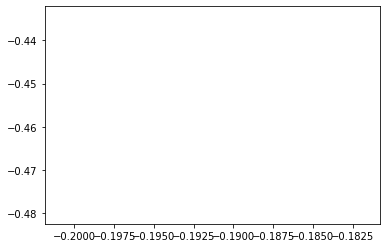

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1
The number of epochs is: 2
The number of epochs is: 3
The number of epochs is: 4
The number of epochs is: 5
The number of epochs is: 6
The number of epochs is: 7
The number of epochs is: 8
The number of epochs is: 9
The number of epochs is: 10
The number of epochs is: 11
The number of epochs is: 12
The number of epochs is: 13
The number of epochs is: 14
The number of epochs is: 15
The number of epochs is: 16
The number of epochs is: 17
The number of epochs is: 18
The number of epochs is: 19
The number of epochs is: 20
The number of epochs is: 21
The number of epochs is: 22
The number of epochs is: 23
The number of epochs is: 24
The number of epochs is: 25
The number of epochs is: 26
The number of epochs is: 27
The number of epochs is: 28
The number of epochs is: 29
The number of epochs is: 30
The number of epochs is: 31
The number of epochs is: 32
The number of epochs is: 33
The number of epochs is: 34
The number of epochs is: 35
The number of epochs is: 36
T

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

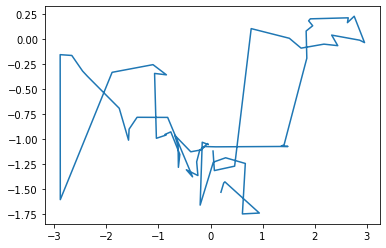

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 101
The number of epochs is: 102
The number of epochs is: 103
The number of epochs is: 104
The number of epochs is: 105
The number of epochs is: 106
The number of epochs is: 107
The number of epochs is: 108
The number of epochs is: 109
The number of epochs is: 110
The number of epochs is: 111
The number of epochs is: 112
The number of epochs is: 113
The number of epochs is: 114
The number of epochs is: 115
The number of epochs is: 116
The number of epochs is: 117
The number of epochs is: 118
The number of epochs is: 119
The number of epochs is: 120
The number of epochs is: 121
The number of epochs is: 122
The number of epochs is: 123
The number of epochs is: 124
The number of epochs is: 125
The number of epochs is: 126
The number of epochs is: 127
The number of epochs is: 128
The number of epochs is: 129
The number of epochs is: 130
The number of epochs is: 131
The number of epochs is: 132
The number of epochs is: 133
The number of epochs is: 134
The number of 

<Figure size 432x288 with 0 Axes>

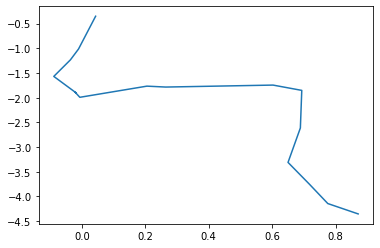

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 201
The number of epochs is: 202
The number of epochs is: 203
The number of epochs is: 204
The number of epochs is: 205
The number of epochs is: 206
The number of epochs is: 207
The number of epochs is: 208
The number of epochs is: 209
The number of epochs is: 210
The number of epochs is: 211
The number of epochs is: 212
The number of epochs is: 213
The number of epochs is: 214
The number of epochs is: 215
The number of epochs is: 216
The number of epochs is: 217
The number of epochs is: 218
The number of epochs is: 219
The number of epochs is: 220
The number of epochs is: 221
The number of epochs is: 222
The number of epochs is: 223
The number of epochs is: 224
The number of epochs is: 225
The number of epochs is: 226
The number of epochs is: 227
The number of epochs is: 228
The number of epochs is: 229
The number of epochs is: 230
The number of epochs is: 231
The number of epochs is: 232
The number of epochs is: 233
The number of epochs is: 234
The number of 

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

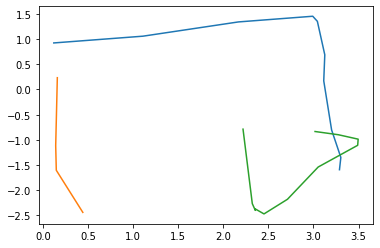

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 301
The number of epochs is: 302
The number of epochs is: 303
The number of epochs is: 304
The number of epochs is: 305
The number of epochs is: 306
The number of epochs is: 307
The number of epochs is: 308
The number of epochs is: 309
The number of epochs is: 310
The number of epochs is: 311
The number of epochs is: 312
The number of epochs is: 313
The number of epochs is: 314
The number of epochs is: 315
The number of epochs is: 316
The number of epochs is: 317
The number of epochs is: 318
The number of epochs is: 319
The number of epochs is: 320
The number of epochs is: 321
The number of epochs is: 322
The number of epochs is: 323
The number of epochs is: 324
The number of epochs is: 325
The number of epochs is: 326
The number of epochs is: 327
The number of epochs is: 328
The number of epochs is: 329
The number of epochs is: 330
The number of epochs is: 331
The number of epochs is: 332
The number of epochs is: 333
The number of epochs is: 334
The number of 

<Figure size 432x288 with 0 Axes>

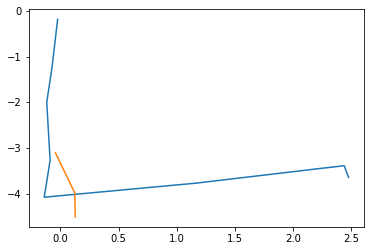

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 401
The number of epochs is: 402
The number of epochs is: 403
The number of epochs is: 404
The number of epochs is: 405
The number of epochs is: 406
The number of epochs is: 407
The number of epochs is: 408
The number of epochs is: 409
The number of epochs is: 410
The number of epochs is: 411
The number of epochs is: 412
The number of epochs is: 413
The number of epochs is: 414
The number of epochs is: 415
The number of epochs is: 416
The number of epochs is: 417
The number of epochs is: 418
The number of epochs is: 419
The number of epochs is: 420
The number of epochs is: 421
The number of epochs is: 422
The number of epochs is: 423
The number of epochs is: 424
The number of epochs is: 425
The number of epochs is: 426
The number of epochs is: 427
The number of epochs is: 428
The number of epochs is: 429
The number of epochs is: 430
The number of epochs is: 431
The number of epochs is: 432
The number of epochs is: 433
The number of epochs is: 434
The number of 

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

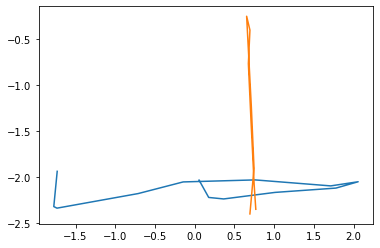

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 501
The number of epochs is: 502
The number of epochs is: 503
The number of epochs is: 504
The number of epochs is: 505
The number of epochs is: 506
The number of epochs is: 507
The number of epochs is: 508
The number of epochs is: 509
The number of epochs is: 510
The number of epochs is: 511
The number of epochs is: 512
The number of epochs is: 513
The number of epochs is: 514
The number of epochs is: 515
The number of epochs is: 516
The number of epochs is: 517
The number of epochs is: 518
The number of epochs is: 519
The number of epochs is: 520
The number of epochs is: 521
The number of epochs is: 522
The number of epochs is: 523
The number of epochs is: 524
The number of epochs is: 525
The number of epochs is: 526
The number of epochs is: 527
The number of epochs is: 528
The number of epochs is: 529
The number of epochs is: 530
The number of epochs is: 531
The number of epochs is: 532
The number of epochs is: 533
The number of epochs is: 534
The number of 

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

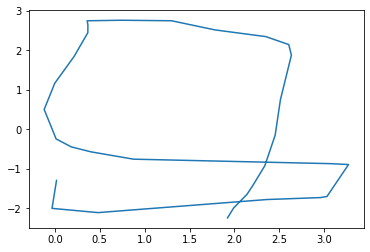

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 601
The number of epochs is: 602
The number of epochs is: 603
The number of epochs is: 604
The number of epochs is: 605
The number of epochs is: 606
The number of epochs is: 607
The number of epochs is: 608
The number of epochs is: 609
The number of epochs is: 610
The number of epochs is: 611
The number of epochs is: 612
The number of epochs is: 613
The number of epochs is: 614
The number of epochs is: 615
The number of epochs is: 616
The number of epochs is: 617
The number of epochs is: 618
The number of epochs is: 619
The number of epochs is: 620
The number of epochs is: 621
The number of epochs is: 622
The number of epochs is: 623
The number of epochs is: 624
The number of epochs is: 625
The number of epochs is: 626
The number of epochs is: 627
The number of epochs is: 628
The number of epochs is: 629
The number of epochs is: 630
The number of epochs is: 631
The number of epochs is: 632
The number of epochs is: 633
The number of epochs is: 634
The number of 

<Figure size 432x288 with 0 Axes>

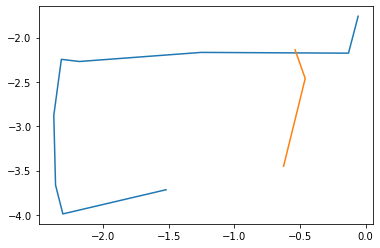

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 701
The number of epochs is: 702
The number of epochs is: 703
The number of epochs is: 704
The number of epochs is: 705
The number of epochs is: 706
The number of epochs is: 707
The number of epochs is: 708
The number of epochs is: 709
The number of epochs is: 710
The number of epochs is: 711
The number of epochs is: 712
The number of epochs is: 713
The number of epochs is: 714
The number of epochs is: 715
The number of epochs is: 716
The number of epochs is: 717
The number of epochs is: 718
The number of epochs is: 719
The number of epochs is: 720
The number of epochs is: 721
The number of epochs is: 722
The number of epochs is: 723
The number of epochs is: 724
The number of epochs is: 725
The number of epochs is: 726
The number of epochs is: 727
The number of epochs is: 728
The number of epochs is: 729
The number of epochs is: 730
The number of epochs is: 731
The number of epochs is: 732
The number of epochs is: 733
The number of epochs is: 734
The number of 

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

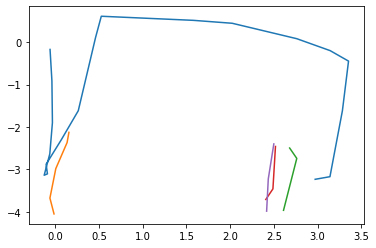

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 801
The number of epochs is: 802
The number of epochs is: 803
The number of epochs is: 804
The number of epochs is: 805
The number of epochs is: 806
The number of epochs is: 807
The number of epochs is: 808
The number of epochs is: 809
The number of epochs is: 810
The number of epochs is: 811
The number of epochs is: 812
The number of epochs is: 813
The number of epochs is: 814
The number of epochs is: 815
The number of epochs is: 816
The number of epochs is: 817
The number of epochs is: 818
The number of epochs is: 819
The number of epochs is: 820
The number of epochs is: 821
The number of epochs is: 822
The number of epochs is: 823
The number of epochs is: 824
The number of epochs is: 825
The number of epochs is: 826
The number of epochs is: 827
The number of epochs is: 828
The number of epochs is: 829
The number of epochs is: 830
The number of epochs is: 831
The number of epochs is: 832
The number of epochs is: 833
The number of epochs is: 834
The number of 

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

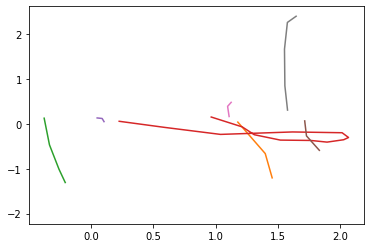

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 901
The number of epochs is: 902
The number of epochs is: 903
The number of epochs is: 904
The number of epochs is: 905
The number of epochs is: 906
The number of epochs is: 907
The number of epochs is: 908
The number of epochs is: 909
The number of epochs is: 910
The number of epochs is: 911
The number of epochs is: 912
The number of epochs is: 913
The number of epochs is: 914
The number of epochs is: 915
The number of epochs is: 916
The number of epochs is: 917
The number of epochs is: 918
The number of epochs is: 919
The number of epochs is: 920
The number of epochs is: 921
The number of epochs is: 922
The number of epochs is: 923
The number of epochs is: 924
The number of epochs is: 925
The number of epochs is: 926
The number of epochs is: 927
The number of epochs is: 928
The number of epochs is: 929
The number of epochs is: 930
The number of epochs is: 931
The number of epochs is: 932
The number of epochs is: 933
The number of epochs is: 934
The number of 

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

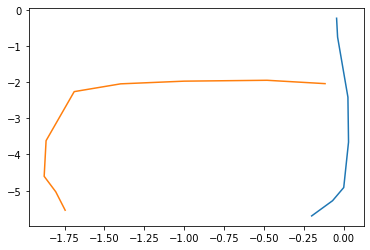

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1001
The number of epochs is: 1002
The number of epochs is: 1003
The number of epochs is: 1004
The number of epochs is: 1005
The number of epochs is: 1006
The number of epochs is: 1007
The number of epochs is: 1008
The number of epochs is: 1009
The number of epochs is: 1010
The number of epochs is: 1011
The number of epochs is: 1012
The number of epochs is: 1013
The number of epochs is: 1014
The number of epochs is: 1015
The number of epochs is: 1016
The number of epochs is: 1017
The number of epochs is: 1018
The number of epochs is: 1019
The number of epochs is: 1020
The number of epochs is: 1021
The number of epochs is: 1022
The number of epochs is: 1023
The number of epochs is: 1024
The number of epochs is: 1025
The number of epochs is: 1026
The number of epochs is: 1027
The number of epochs is: 1028
The number of epochs is: 1029
The number of epochs is: 1030
The number of epochs is: 1031
The number of epochs is: 1032
The number of epochs is: 1033
The number

<Figure size 432x288 with 0 Axes>

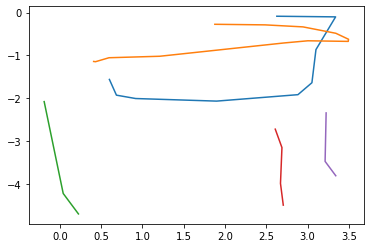

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1101
The number of epochs is: 1102
The number of epochs is: 1103
The number of epochs is: 1104
The number of epochs is: 1105
The number of epochs is: 1106
The number of epochs is: 1107
The number of epochs is: 1108
The number of epochs is: 1109
The number of epochs is: 1110
The number of epochs is: 1111
The number of epochs is: 1112
The number of epochs is: 1113
The number of epochs is: 1114
The number of epochs is: 1115
The number of epochs is: 1116
The number of epochs is: 1117
The number of epochs is: 1118
The number of epochs is: 1119
The number of epochs is: 1120
The number of epochs is: 1121
The number of epochs is: 1122
The number of epochs is: 1123
The number of epochs is: 1124
The number of epochs is: 1125
The number of epochs is: 1126
The number of epochs is: 1127
The number of epochs is: 1128
The number of epochs is: 1129
The number of epochs is: 1130
The number of epochs is: 1131
The number of epochs is: 1132
The number of epochs is: 1133
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

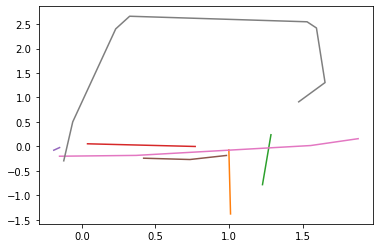

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1201
The number of epochs is: 1202
The number of epochs is: 1203
The number of epochs is: 1204
The number of epochs is: 1205
The number of epochs is: 1206
The number of epochs is: 1207
The number of epochs is: 1208
The number of epochs is: 1209
The number of epochs is: 1210
The number of epochs is: 1211
The number of epochs is: 1212
The number of epochs is: 1213
The number of epochs is: 1214
The number of epochs is: 1215
The number of epochs is: 1216
The number of epochs is: 1217
The number of epochs is: 1218
The number of epochs is: 1219
The number of epochs is: 1220
The number of epochs is: 1221
The number of epochs is: 1222
The number of epochs is: 1223
The number of epochs is: 1224
The number of epochs is: 1225
The number of epochs is: 1226
The number of epochs is: 1227
The number of epochs is: 1228
The number of epochs is: 1229
The number of epochs is: 1230
The number of epochs is: 1231
The number of epochs is: 1232
The number of epochs is: 1233
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

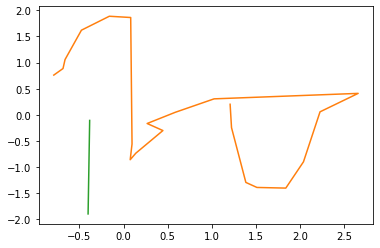

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1301
The number of epochs is: 1302
The number of epochs is: 1303
The number of epochs is: 1304
The number of epochs is: 1305
The number of epochs is: 1306
The number of epochs is: 1307
The number of epochs is: 1308
The number of epochs is: 1309
The number of epochs is: 1310
The number of epochs is: 1311
The number of epochs is: 1312
The number of epochs is: 1313
The number of epochs is: 1314
The number of epochs is: 1315
The number of epochs is: 1316
The number of epochs is: 1317
The number of epochs is: 1318
The number of epochs is: 1319
The number of epochs is: 1320
The number of epochs is: 1321
The number of epochs is: 1322
The number of epochs is: 1323
The number of epochs is: 1324
The number of epochs is: 1325
The number of epochs is: 1326
The number of epochs is: 1327
The number of epochs is: 1328
The number of epochs is: 1329
The number of epochs is: 1330
The number of epochs is: 1331
The number of epochs is: 1332
The number of epochs is: 1333
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

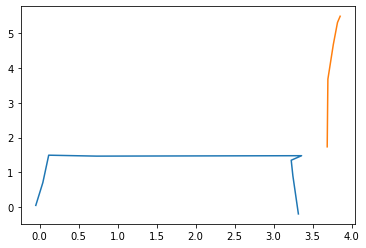

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1401
The number of epochs is: 1402
The number of epochs is: 1403
The number of epochs is: 1404
The number of epochs is: 1405
The number of epochs is: 1406
The number of epochs is: 1407
The number of epochs is: 1408
The number of epochs is: 1409
The number of epochs is: 1410
The number of epochs is: 1411
The number of epochs is: 1412
The number of epochs is: 1413
The number of epochs is: 1414
The number of epochs is: 1415
The number of epochs is: 1416
The number of epochs is: 1417
The number of epochs is: 1418
The number of epochs is: 1419
The number of epochs is: 1420
The number of epochs is: 1421
The number of epochs is: 1422
The number of epochs is: 1423
The number of epochs is: 1424
The number of epochs is: 1425
The number of epochs is: 1426
The number of epochs is: 1427
The number of epochs is: 1428
The number of epochs is: 1429
The number of epochs is: 1430
The number of epochs is: 1431
The number of epochs is: 1432
The number of epochs is: 1433
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

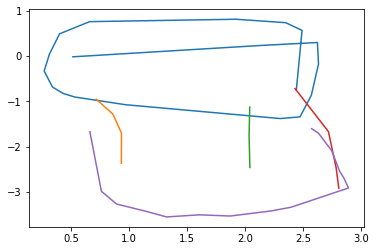

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1501
The number of epochs is: 1502
The number of epochs is: 1503
The number of epochs is: 1504
The number of epochs is: 1505
The number of epochs is: 1506
The number of epochs is: 1507
The number of epochs is: 1508
The number of epochs is: 1509
The number of epochs is: 1510
The number of epochs is: 1511
The number of epochs is: 1512
The number of epochs is: 1513
The number of epochs is: 1514
The number of epochs is: 1515
The number of epochs is: 1516
The number of epochs is: 1517
The number of epochs is: 1518
The number of epochs is: 1519
The number of epochs is: 1520
The number of epochs is: 1521
The number of epochs is: 1522
The number of epochs is: 1523
The number of epochs is: 1524
The number of epochs is: 1525
The number of epochs is: 1526
The number of epochs is: 1527
The number of epochs is: 1528
The number of epochs is: 1529
The number of epochs is: 1530
The number of epochs is: 1531
The number of epochs is: 1532
The number of epochs is: 1533
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

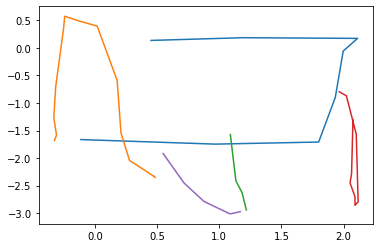

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1601
The number of epochs is: 1602
The number of epochs is: 1603
The number of epochs is: 1604
The number of epochs is: 1605
The number of epochs is: 1606
The number of epochs is: 1607
The number of epochs is: 1608
The number of epochs is: 1609
The number of epochs is: 1610
The number of epochs is: 1611
The number of epochs is: 1612
The number of epochs is: 1613
The number of epochs is: 1614
The number of epochs is: 1615
The number of epochs is: 1616
The number of epochs is: 1617
The number of epochs is: 1618
The number of epochs is: 1619
The number of epochs is: 1620
The number of epochs is: 1621
The number of epochs is: 1622
The number of epochs is: 1623
The number of epochs is: 1624
The number of epochs is: 1625
The number of epochs is: 1626
The number of epochs is: 1627
The number of epochs is: 1628
The number of epochs is: 1629
The number of epochs is: 1630
The number of epochs is: 1631
The number of epochs is: 1632
The number of epochs is: 1633
The number

<Figure size 432x288 with 0 Axes>

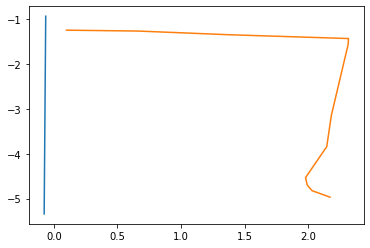

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1701
The number of epochs is: 1702
The number of epochs is: 1703
The number of epochs is: 1704
The number of epochs is: 1705
The number of epochs is: 1706
The number of epochs is: 1707
The number of epochs is: 1708
The number of epochs is: 1709
The number of epochs is: 1710
The number of epochs is: 1711
The number of epochs is: 1712
The number of epochs is: 1713
The number of epochs is: 1714
The number of epochs is: 1715
The number of epochs is: 1716
The number of epochs is: 1717
The number of epochs is: 1718
The number of epochs is: 1719
The number of epochs is: 1720
The number of epochs is: 1721
The number of epochs is: 1722
The number of epochs is: 1723
The number of epochs is: 1724
The number of epochs is: 1725
The number of epochs is: 1726
The number of epochs is: 1727
The number of epochs is: 1728
The number of epochs is: 1729
The number of epochs is: 1730
The number of epochs is: 1731
The number of epochs is: 1732
The number of epochs is: 1733
The number

<Figure size 432x288 with 0 Axes>

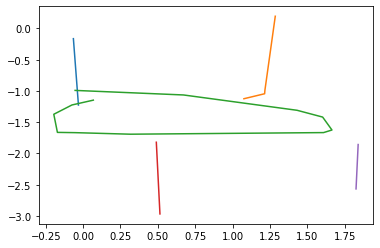

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1801
The number of epochs is: 1802
The number of epochs is: 1803
The number of epochs is: 1804
The number of epochs is: 1805
The number of epochs is: 1806
The number of epochs is: 1807
The number of epochs is: 1808
The number of epochs is: 1809
The number of epochs is: 1810
The number of epochs is: 1811
The number of epochs is: 1812
The number of epochs is: 1813
The number of epochs is: 1814
The number of epochs is: 1815
The number of epochs is: 1816
The number of epochs is: 1817
The number of epochs is: 1818
The number of epochs is: 1819
The number of epochs is: 1820
The number of epochs is: 1821
The number of epochs is: 1822
The number of epochs is: 1823
The number of epochs is: 1824
The number of epochs is: 1825
The number of epochs is: 1826
The number of epochs is: 1827
The number of epochs is: 1828
The number of epochs is: 1829
The number of epochs is: 1830
The number of epochs is: 1831
The number of epochs is: 1832
The number of epochs is: 1833
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

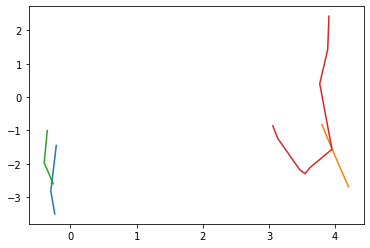

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 1901
The number of epochs is: 1902
The number of epochs is: 1903
The number of epochs is: 1904
The number of epochs is: 1905
The number of epochs is: 1906
The number of epochs is: 1907
The number of epochs is: 1908
The number of epochs is: 1909
The number of epochs is: 1910
The number of epochs is: 1911
The number of epochs is: 1912
The number of epochs is: 1913
The number of epochs is: 1914
The number of epochs is: 1915
The number of epochs is: 1916
The number of epochs is: 1917
The number of epochs is: 1918
The number of epochs is: 1919
The number of epochs is: 1920
The number of epochs is: 1921
The number of epochs is: 1922
The number of epochs is: 1923
The number of epochs is: 1924
The number of epochs is: 1925
The number of epochs is: 1926
The number of epochs is: 1927
The number of epochs is: 1928
The number of epochs is: 1929
The number of epochs is: 1930
The number of epochs is: 1931
The number of epochs is: 1932
The number of epochs is: 1933
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

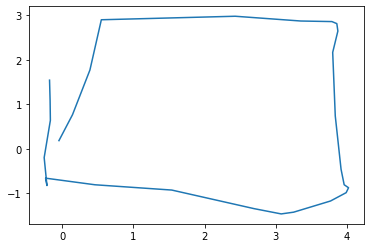

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2001
The number of epochs is: 2002
The number of epochs is: 2003
The number of epochs is: 2004
The number of epochs is: 2005
The number of epochs is: 2006
The number of epochs is: 2007
The number of epochs is: 2008
The number of epochs is: 2009
The number of epochs is: 2010
The number of epochs is: 2011
The number of epochs is: 2012
The number of epochs is: 2013
The number of epochs is: 2014
The number of epochs is: 2015
The number of epochs is: 2016
The number of epochs is: 2017
The number of epochs is: 2018
The number of epochs is: 2019
The number of epochs is: 2020
The number of epochs is: 2021
The number of epochs is: 2022
The number of epochs is: 2023
The number of epochs is: 2024
The number of epochs is: 2025
The number of epochs is: 2026
The number of epochs is: 2027
The number of epochs is: 2028
The number of epochs is: 2029
The number of epochs is: 2030
The number of epochs is: 2031
The number of epochs is: 2032
The number of epochs is: 2033
The number

<Figure size 432x288 with 0 Axes>

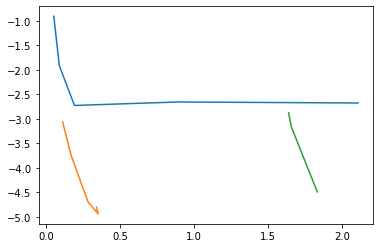

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2101
The number of epochs is: 2102
The number of epochs is: 2103
The number of epochs is: 2104
The number of epochs is: 2105
The number of epochs is: 2106
The number of epochs is: 2107
The number of epochs is: 2108
The number of epochs is: 2109
The number of epochs is: 2110
The number of epochs is: 2111
The number of epochs is: 2112
The number of epochs is: 2113
The number of epochs is: 2114
The number of epochs is: 2115
The number of epochs is: 2116
The number of epochs is: 2117
The number of epochs is: 2118
The number of epochs is: 2119
The number of epochs is: 2120
The number of epochs is: 2121
The number of epochs is: 2122
The number of epochs is: 2123
The number of epochs is: 2124
The number of epochs is: 2125
The number of epochs is: 2126
The number of epochs is: 2127
The number of epochs is: 2128
The number of epochs is: 2129
The number of epochs is: 2130
The number of epochs is: 2131
The number of epochs is: 2132
The number of epochs is: 2133
The number

<Figure size 432x288 with 0 Axes>

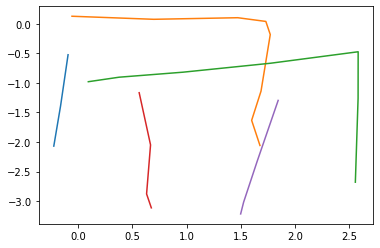

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2201
The number of epochs is: 2202
The number of epochs is: 2203
The number of epochs is: 2204
The number of epochs is: 2205
The number of epochs is: 2206
The number of epochs is: 2207
The number of epochs is: 2208
The number of epochs is: 2209
The number of epochs is: 2210
The number of epochs is: 2211
The number of epochs is: 2212
The number of epochs is: 2213
The number of epochs is: 2214
The number of epochs is: 2215
The number of epochs is: 2216
The number of epochs is: 2217
The number of epochs is: 2218
The number of epochs is: 2219
The number of epochs is: 2220
The number of epochs is: 2221
The number of epochs is: 2222
The number of epochs is: 2223
The number of epochs is: 2224
The number of epochs is: 2225
The number of epochs is: 2226
The number of epochs is: 2227
The number of epochs is: 2228
The number of epochs is: 2229
The number of epochs is: 2230
The number of epochs is: 2231
The number of epochs is: 2232
The number of epochs is: 2233
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

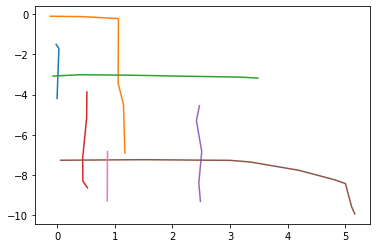

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2301
The number of epochs is: 2302
The number of epochs is: 2303
The number of epochs is: 2304
The number of epochs is: 2305
The number of epochs is: 2306
The number of epochs is: 2307
The number of epochs is: 2308
The number of epochs is: 2309
The number of epochs is: 2310
The number of epochs is: 2311
The number of epochs is: 2312
The number of epochs is: 2313
The number of epochs is: 2314
The number of epochs is: 2315
The number of epochs is: 2316
The number of epochs is: 2317
The number of epochs is: 2318
The number of epochs is: 2319
The number of epochs is: 2320
The number of epochs is: 2321
The number of epochs is: 2322
The number of epochs is: 2323
The number of epochs is: 2324
The number of epochs is: 2325
The number of epochs is: 2326
The number of epochs is: 2327
The number of epochs is: 2328
The number of epochs is: 2329
The number of epochs is: 2330
The number of epochs is: 2331
The number of epochs is: 2332
The number of epochs is: 2333
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

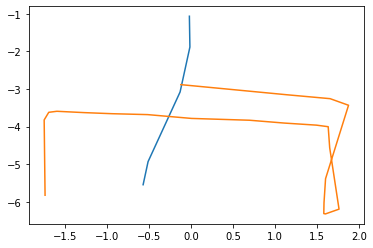

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2401
The number of epochs is: 2402
The number of epochs is: 2403
The number of epochs is: 2404
The number of epochs is: 2405
The number of epochs is: 2406
The number of epochs is: 2407
The number of epochs is: 2408
The number of epochs is: 2409
The number of epochs is: 2410
The number of epochs is: 2411
The number of epochs is: 2412
The number of epochs is: 2413
The number of epochs is: 2414
The number of epochs is: 2415
The number of epochs is: 2416
The number of epochs is: 2417
The number of epochs is: 2418
The number of epochs is: 2419
The number of epochs is: 2420
The number of epochs is: 2421
The number of epochs is: 2422
The number of epochs is: 2423
The number of epochs is: 2424
The number of epochs is: 2425
The number of epochs is: 2426
The number of epochs is: 2427
The number of epochs is: 2428
The number of epochs is: 2429
The number of epochs is: 2430
The number of epochs is: 2431
The number of epochs is: 2432
The number of epochs is: 2433
The number

<Figure size 432x288 with 0 Axes>

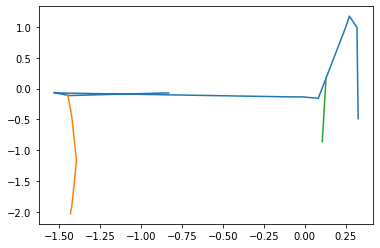

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2501
The number of epochs is: 2502
The number of epochs is: 2503
The number of epochs is: 2504
The number of epochs is: 2505
The number of epochs is: 2506
The number of epochs is: 2507
The number of epochs is: 2508
The number of epochs is: 2509
The number of epochs is: 2510
The number of epochs is: 2511
The number of epochs is: 2512
The number of epochs is: 2513
The number of epochs is: 2514
The number of epochs is: 2515
The number of epochs is: 2516
The number of epochs is: 2517
The number of epochs is: 2518
The number of epochs is: 2519
The number of epochs is: 2520
The number of epochs is: 2521
The number of epochs is: 2522
The number of epochs is: 2523
The number of epochs is: 2524
The number of epochs is: 2525
The number of epochs is: 2526
The number of epochs is: 2527
The number of epochs is: 2528
The number of epochs is: 2529
The number of epochs is: 2530
The number of epochs is: 2531
The number of epochs is: 2532
The number of epochs is: 2533
The number

<Figure size 432x288 with 0 Axes>

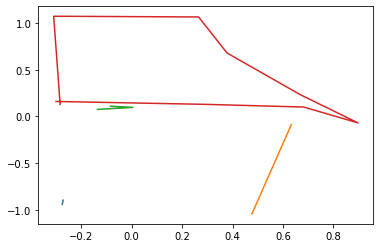

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2601
The number of epochs is: 2602
The number of epochs is: 2603
The number of epochs is: 2604
The number of epochs is: 2605
The number of epochs is: 2606
The number of epochs is: 2607
The number of epochs is: 2608
The number of epochs is: 2609
The number of epochs is: 2610
The number of epochs is: 2611
The number of epochs is: 2612
The number of epochs is: 2613
The number of epochs is: 2614
The number of epochs is: 2615
The number of epochs is: 2616
The number of epochs is: 2617
The number of epochs is: 2618
The number of epochs is: 2619
The number of epochs is: 2620
The number of epochs is: 2621
The number of epochs is: 2622
The number of epochs is: 2623
The number of epochs is: 2624
The number of epochs is: 2625
The number of epochs is: 2626
The number of epochs is: 2627
The number of epochs is: 2628
The number of epochs is: 2629
The number of epochs is: 2630
The number of epochs is: 2631
The number of epochs is: 2632
The number of epochs is: 2633
The number

<Figure size 432x288 with 0 Axes>

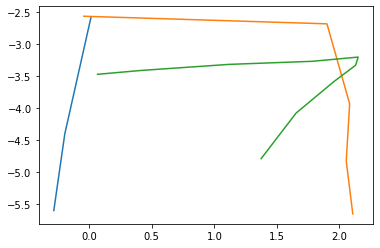

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2701
The number of epochs is: 2702
The number of epochs is: 2703
The number of epochs is: 2704
The number of epochs is: 2705
The number of epochs is: 2706
The number of epochs is: 2707
The number of epochs is: 2708
The number of epochs is: 2709
The number of epochs is: 2710
The number of epochs is: 2711
The number of epochs is: 2712
The number of epochs is: 2713
The number of epochs is: 2714
The number of epochs is: 2715
The number of epochs is: 2716
The number of epochs is: 2717
The number of epochs is: 2718
The number of epochs is: 2719
The number of epochs is: 2720
The number of epochs is: 2721
The number of epochs is: 2722
The number of epochs is: 2723
The number of epochs is: 2724
The number of epochs is: 2725
The number of epochs is: 2726
The number of epochs is: 2727
The number of epochs is: 2728
The number of epochs is: 2729
The number of epochs is: 2730
The number of epochs is: 2731
The number of epochs is: 2732
The number of epochs is: 2733
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

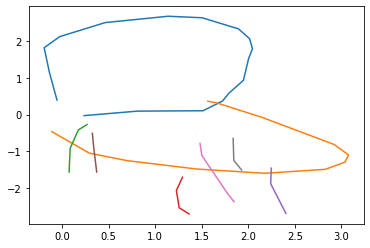

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2801
The number of epochs is: 2802
The number of epochs is: 2803
The number of epochs is: 2804
The number of epochs is: 2805
The number of epochs is: 2806
The number of epochs is: 2807
The number of epochs is: 2808
The number of epochs is: 2809
The number of epochs is: 2810
The number of epochs is: 2811
The number of epochs is: 2812
The number of epochs is: 2813
The number of epochs is: 2814
The number of epochs is: 2815
The number of epochs is: 2816
The number of epochs is: 2817
The number of epochs is: 2818
The number of epochs is: 2819
The number of epochs is: 2820
The number of epochs is: 2821
The number of epochs is: 2822
The number of epochs is: 2823
The number of epochs is: 2824
The number of epochs is: 2825
The number of epochs is: 2826
The number of epochs is: 2827
The number of epochs is: 2828
The number of epochs is: 2829
The number of epochs is: 2830
The number of epochs is: 2831
The number of epochs is: 2832
The number of epochs is: 2833
The number

<Figure size 432x288 with 0 Axes>

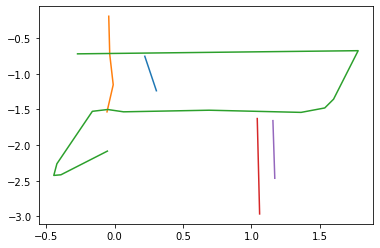

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 2901
The number of epochs is: 2902
The number of epochs is: 2903
The number of epochs is: 2904
The number of epochs is: 2905
The number of epochs is: 2906
The number of epochs is: 2907
The number of epochs is: 2908
The number of epochs is: 2909
The number of epochs is: 2910
The number of epochs is: 2911
The number of epochs is: 2912
The number of epochs is: 2913
The number of epochs is: 2914
The number of epochs is: 2915
The number of epochs is: 2916
The number of epochs is: 2917
The number of epochs is: 2918
The number of epochs is: 2919
The number of epochs is: 2920
The number of epochs is: 2921
The number of epochs is: 2922
The number of epochs is: 2923
The number of epochs is: 2924
The number of epochs is: 2925
The number of epochs is: 2926
The number of epochs is: 2927
The number of epochs is: 2928
The number of epochs is: 2929
The number of epochs is: 2930
The number of epochs is: 2931
The number of epochs is: 2932
The number of epochs is: 2933
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

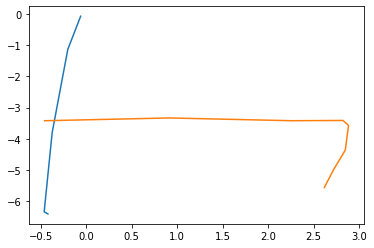

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 3001
The number of epochs is: 3002
The number of epochs is: 3003
The number of epochs is: 3004
The number of epochs is: 3005
The number of epochs is: 3006
The number of epochs is: 3007
The number of epochs is: 3008
The number of epochs is: 3009
The number of epochs is: 3010
The number of epochs is: 3011
The number of epochs is: 3012
The number of epochs is: 3013
The number of epochs is: 3014
The number of epochs is: 3015
The number of epochs is: 3016
The number of epochs is: 3017
The number of epochs is: 3018
The number of epochs is: 3019
The number of epochs is: 3020
The number of epochs is: 3021
The number of epochs is: 3022
The number of epochs is: 3023
The number of epochs is: 3024
The number of epochs is: 3025
The number of epochs is: 3026
The number of epochs is: 3027
The number of epochs is: 3028
The number of epochs is: 3029
The number of epochs is: 3030
The number of epochs is: 3031
The number of epochs is: 3032
The number of epochs is: 3033
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

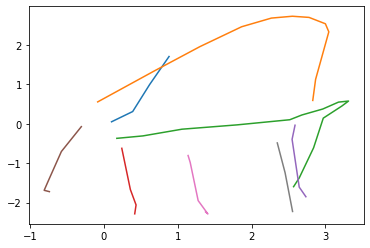

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 3101
The number of epochs is: 3102
The number of epochs is: 3103
The number of epochs is: 3104
The number of epochs is: 3105
The number of epochs is: 3106
The number of epochs is: 3107
The number of epochs is: 3108
The number of epochs is: 3109
The number of epochs is: 3110
The number of epochs is: 3111
The number of epochs is: 3112
The number of epochs is: 3113
The number of epochs is: 3114
The number of epochs is: 3115
The number of epochs is: 3116
The number of epochs is: 3117
The number of epochs is: 3118
The number of epochs is: 3119
The number of epochs is: 3120
The number of epochs is: 3121
The number of epochs is: 3122
The number of epochs is: 3123
The number of epochs is: 3124
The number of epochs is: 3125
The number of epochs is: 3126
The number of epochs is: 3127
The number of epochs is: 3128
The number of epochs is: 3129
The number of epochs is: 3130
The number of epochs is: 3131
The number of epochs is: 3132
The number of epochs is: 3133
The number

<Figure size 432x288 with 0 Axes>

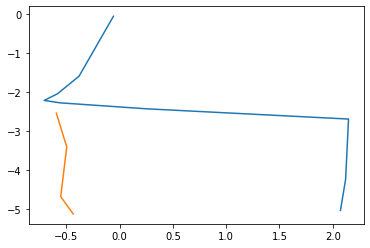

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 3201
The number of epochs is: 3202
The number of epochs is: 3203
The number of epochs is: 3204
The number of epochs is: 3205
The number of epochs is: 3206
The number of epochs is: 3207
The number of epochs is: 3208
The number of epochs is: 3209
The number of epochs is: 3210
The number of epochs is: 3211
The number of epochs is: 3212
The number of epochs is: 3213
The number of epochs is: 3214
The number of epochs is: 3215
The number of epochs is: 3216
The number of epochs is: 3217
The number of epochs is: 3218
The number of epochs is: 3219
The number of epochs is: 3220
The number of epochs is: 3221
The number of epochs is: 3222
The number of epochs is: 3223
The number of epochs is: 3224
The number of epochs is: 3225
The number of epochs is: 3226
The number of epochs is: 3227
The number of epochs is: 3228
The number of epochs is: 3229
The number of epochs is: 3230
The number of epochs is: 3231
The number of epochs is: 3232
The number of epochs is: 3233
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Outputting sketch


<Figure size 432x288 with 0 Axes>

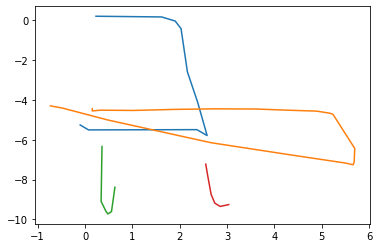

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 3301
The number of epochs is: 3302
The number of epochs is: 3303
The number of epochs is: 3304
The number of epochs is: 3305
The number of epochs is: 3306
The number of epochs is: 3307
The number of epochs is: 3308
The number of epochs is: 3309
The number of epochs is: 3310
The number of epochs is: 3311
The number of epochs is: 3312
The number of epochs is: 3313
The number of epochs is: 3314
The number of epochs is: 3315
The number of epochs is: 3316
The number of epochs is: 3317
The number of epochs is: 3318
The number of epochs is: 3319
The number of epochs is: 3320
The number of epochs is: 3321
The number of epochs is: 3322
The number of epochs is: 3323
The number of epochs is: 3324
The number of epochs is: 3325
The number of epochs is: 3326
The number of epochs is: 3327
The number of epochs is: 3328
The number of epochs is: 3329
The number of epochs is: 3330
The number of epochs is: 3331
The number of epochs is: 3332
The number of epochs is: 3333
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

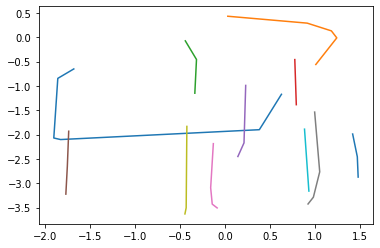

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 3401
The number of epochs is: 3402
The number of epochs is: 3403
The number of epochs is: 3404
The number of epochs is: 3405
The number of epochs is: 3406
The number of epochs is: 3407
The number of epochs is: 3408
The number of epochs is: 3409
The number of epochs is: 3410
The number of epochs is: 3411
The number of epochs is: 3412
The number of epochs is: 3413
The number of epochs is: 3414
The number of epochs is: 3415
The number of epochs is: 3416
The number of epochs is: 3417
The number of epochs is: 3418
The number of epochs is: 3419
The number of epochs is: 3420
The number of epochs is: 3421
The number of epochs is: 3422
The number of epochs is: 3423
The number of epochs is: 3424
The number of epochs is: 3425
The number of epochs is: 3426
The number of epochs is: 3427
The number of epochs is: 3428
The number of epochs is: 3429
The number of epochs is: 3430
The number of epochs is: 3431
The number of epochs is: 3432
The number of epochs is: 3433
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

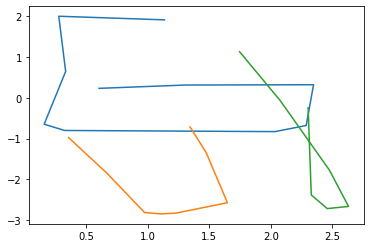

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 3501
The number of epochs is: 3502
The number of epochs is: 3503
The number of epochs is: 3504
The number of epochs is: 3505
The number of epochs is: 3506
The number of epochs is: 3507
The number of epochs is: 3508
The number of epochs is: 3509
The number of epochs is: 3510
The number of epochs is: 3511
The number of epochs is: 3512
The number of epochs is: 3513
The number of epochs is: 3514
The number of epochs is: 3515
The number of epochs is: 3516
The number of epochs is: 3517
The number of epochs is: 3518
The number of epochs is: 3519
The number of epochs is: 3520
The number of epochs is: 3521
The number of epochs is: 3522
The number of epochs is: 3523
The number of epochs is: 3524
The number of epochs is: 3525
The number of epochs is: 3526
The number of epochs is: 3527
The number of epochs is: 3528
The number of epochs is: 3529
The number of epochs is: 3530
The number of epochs is: 3531
The number of epochs is: 3532
The number of epochs is: 3533
The number

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<Figure size 432x288 with 0 Axes>

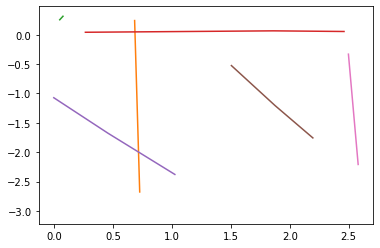

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 3601
The number of epochs is: 3602
The number of epochs is: 3603
The number of epochs is: 3604
The number of epochs is: 3605
The number of epochs is: 3606
The number of epochs is: 3607
The number of epochs is: 3608
The number of epochs is: 3609
The number of epochs is: 3610
The number of epochs is: 3611
The number of epochs is: 3612
The number of epochs is: 3613
The number of epochs is: 3614
The number of epochs is: 3615
The number of epochs is: 3616
The number of epochs is: 3617
The number of epochs is: 3618
The number of epochs is: 3619
The number of epochs is: 3620
The number of epochs is: 3621
The number of epochs is: 3622
The number of epochs is: 3623
The number of epochs is: 3624
The number of epochs is: 3625
The number of epochs is: 3626
The number of epochs is: 3627
The number of epochs is: 3628
The number of epochs is: 3629
The number of epochs is: 3630
The number of epochs is: 3631
The number of epochs is: 3632
The number of epochs is: 3633
The number

<Figure size 432x288 with 0 Axes>

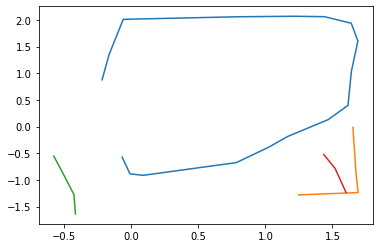

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm

The number of epochs is: 3701
The number of epochs is: 3702
The number of epochs is: 3703
The number of epochs is: 3704
The number of epochs is: 3705
The number of epochs is: 3706
The number of epochs is: 3707
The number of epochs is: 3708
The number of epochs is: 3709
The number of epochs is: 3710
The number of epochs is: 3711
The number of epochs is: 3712
The number of epochs is: 3713
The number of epochs is: 3714
The number of epochs is: 3715
The number of epochs is: 3716
The number of epochs is: 3717
The number of epochs is: 3718
The number of epochs is: 3719
The number of epochs is: 3720
The number of epochs is: 3721


In [ ]:
model = Model()
for epoch in range(50001):
    model.train(epoch)